In [1]:
from TSInterpret.data import load_data
import sklearn
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
from tslearn.datasets import UCR_UEA_datasets
import os 

In [2]:
dataset='NATOPS'

In [3]:
X_train,y_train, X_test, y_test=UCR_UEA_datasets().load_dataset(dataset)
train_x=X_train.reshape(-1,X_train.shape[-1],X_train.shape[-2])
test_x=X_test.reshape(-1,X_train.shape[-1],X_train.shape[-2])
train_y = y_train
test_y=y_test



In [4]:
print(train_x.shape)
print(X_train.shape)

(180, 24, 51)
(180, 51, 24)


In [5]:
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(train_y.reshape(-1,1))
pickle.dump(enc1,open(f'../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','wb'))
train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))



In [6]:
n_pred_classes =train_y.shape[1]
print('n pred classes',n_pred_classes) 
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)


n pred classes 6


In [7]:
model = ResNetBaseline(in_channels= X_train.shape[-1], num_pred_classes=n_pred_classes)
fit(model,train_loader,test_loader)
if dataset in os.listdir('../ClassificationModels/models/'):
    print('Folder exists')
else: 
    os.mkdir(f'../ClassificationModels/models/{dataset}')
torch.save(model.state_dict(), f'../ClassificationModels/models/{dataset}/ResNet')

test_preds, ground_truth = get_all_preds(model, test_loader)
ground_truth=np.argmax(ground_truth,axis=1)
#test_preds=np.argmax(test_preds,axis=1)
sns.set(rc={'figure.figsize':(5,4)})
heatmap=confusion_matrix(ground_truth, test_preds)
sns.heatmap(heatmap, annot=True)
plt.savefig(f'../ClassificationModels/models/{dataset}/ResNet_confusion_matrix.png')
plt.close()
acc= accuracy_score(ground_truth, test_preds)
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'../ClassificationModels/models/{dataset}/classification_report.csv', index = False)



Epoch: 1, Train loss: 1.062, Val loss: 1.266
Epoch: 2, Train loss: 0.932, Val loss: 0.695
Epoch: 3, Train loss: 0.684, Val loss: 0.65
Epoch: 4, Train loss: 0.495, Val loss: 0.492
Epoch: 5, Train loss: 0.436, Val loss: 0.456
Epoch: 6, Train loss: 0.355, Val loss: 0.456
Epoch: 7, Train loss: 0.347, Val loss: 0.634
Epoch: 8, Train loss: 0.292, Val loss: 0.344
Epoch: 9, Train loss: 0.478, Val loss: 0.343
Epoch: 10, Train loss: 0.377, Val loss: 0.469
Epoch: 11, Train loss: 0.319, Val loss: 0.403
Epoch: 12, Train loss: 0.325, Val loss: 0.368
Epoch: 13, Train loss: 0.319, Val loss: 0.326
Epoch: 14, Train loss: 0.362, Val loss: 0.629
Epoch: 15, Train loss: 0.523, Val loss: 0.447
Epoch: 16, Train loss: 0.406, Val loss: 0.631
Epoch: 17, Train loss: 0.46, Val loss: 0.485
Epoch: 18, Train loss: 0.405, Val loss: 0.725
Epoch: 19, Train loss: 0.346, Val loss: 0.542
Epoch: 20, Train loss: 0.404, Val loss: 0.446
Epoch: 21, Train loss: 0.339, Val loss: 0.412
Epoch: 22, Train loss: 0.258, Val loss: 0.362

In [8]:
print(train_x.shape)
print(test_x.shape)
print(X_train.shape[-1])

(180, 24, 51)
(180, 24, 51)
24


# Explanation Algo

In [9]:
item=test_x[0].reshape(1,test_x.shape[1],-1)
shape=item.shape
_item=  torch.from_numpy(item).float()
model.eval()
#y_target= model(_item).detach().numpy()
print(model(_item))
y_target = torch.nn.functional.softmax(model(_item)).detach().numpy()

tensor([[  1.2466,  -7.0217, -72.2538,  43.1904,  -7.6288,   2.8921]],
       grad_fn=<AddmmBackward0>)


/home/jacqueline/.local/share/virtualenvs/TSInterpret-NXJYnQDU/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


In [10]:
print(y_target)

[[6.0819788e-19 1.5601508e-22 0.0000000e+00 1.0000000e+00 8.5013760e-23
  3.1524875e-18]]


In [11]:
from TSInterpret.InterpretabilityModels.counterfactual.Ates import AtesCF
exp_model= AtesCF(model,(train_x,train_y),backend='PYT',mode='feat')


2022-06-13 19:14:30.701483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-13 19:14:30.701500: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [12]:
#TODO Target Calculation  --> Why is opt not working
exp = exp_model.explain(item,3, method= 'opt')


Run Brute Force as Backup.
Best (1, 24, 51)
Other (1,)
Target [2]


In [13]:

array, label=exp


In [14]:
array

array([[[-0.601514, -1.696485, -0.772873, ..., -0.601972, -1.69618 ,
         -0.774896],
        [ 0.599973, -1.917021, -0.838037, ...,  0.597675, -1.918653,
         -0.842211],
        [-0.693295, -0.782851, -0.285175, ..., -0.693346, -0.783805,
         -0.284507],
        ...,
        [ 0.627078, -1.620468, -0.702724, ...,  0.76356 , -1.463721,
         -0.630478],
        [-0.741052, -1.632995, -0.698204, ..., -0.760328, -1.601519,
         -0.697637],
        [ 0.532856, -1.480961, -0.501022, ...,  0.485293, -1.521387,
         -0.584391]]])

# Plot Item 

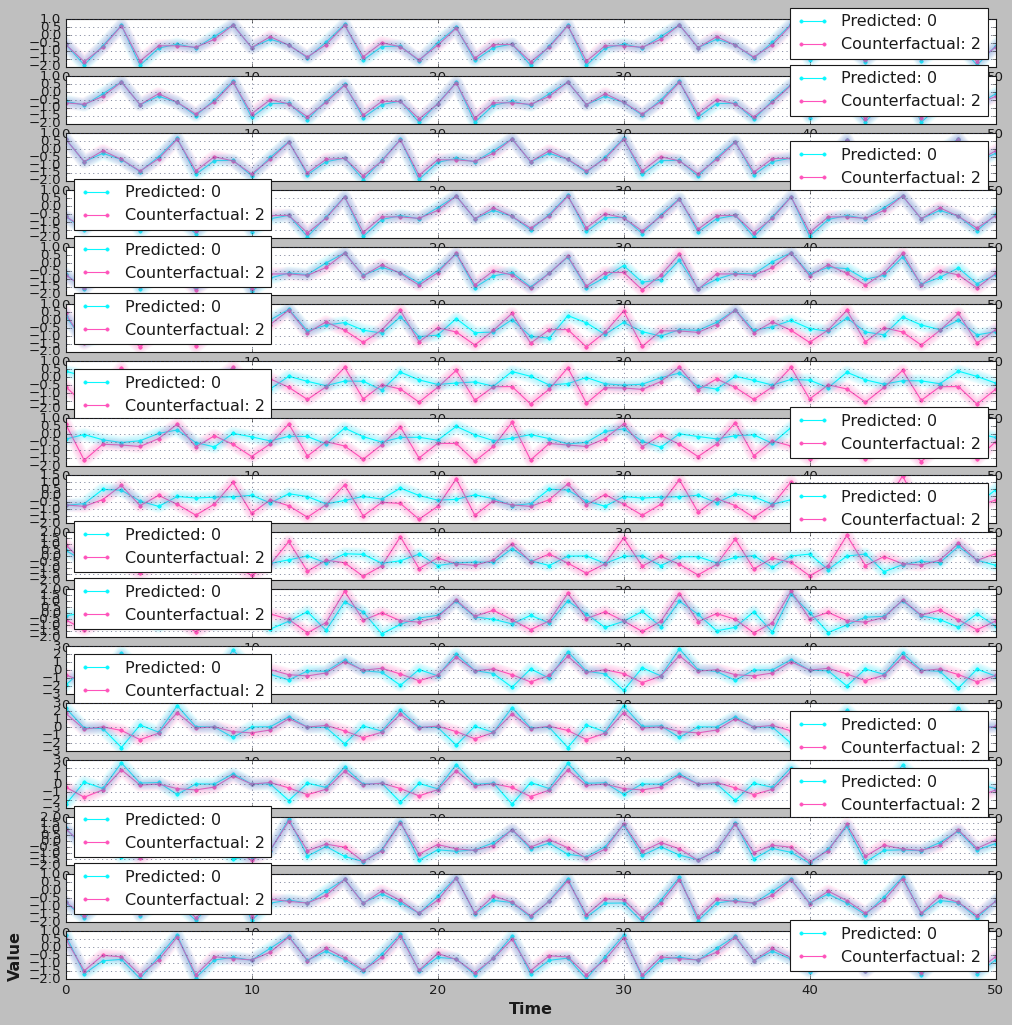

In [15]:
i=0
org_label=0
cf_label=label[0]
exp=array

exp_model.plot(item,org_label,exp,cf_label,figsize=(15,15))